In [1]:
import raw_data
import ta

import math

from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
daily_adjusted_df = raw_data.get_time_series_daily_adjusted("msft")
prediction_period = 30  # predict 30 days in the future

display.display(daily_adjusted_df.describe())
display.display(daily_adjusted_df.head(5))

,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5.960000e+03,5960.000000,5960.000000
mean,55.470969,56.162841,54.785379,55.494916,26.638197,4.237067e+07,0.002562,1.000671
std,34.166645,34.658273,33.658528,34.197385,18.961481,3.046236e+07,0.046281,0.025900
min,15.200000,15.620000,14.870000,15.150000,2.423500,7.111000e+05,0.000000,1.000000
25%,27.417500,27.710000,27.210000,27.457500,17.478850,2.185800e+07,0.000000,1.000000
50%,43.980000,44.500000,43.555000,43.990000,21.428700,3.814835e+07,0.000000,1.000000
75%,77.597500,79.025000,76.690000,77.690000,28.917300,5.712868e+07,0.000000,1.000000
max,178.940000,180.380000,175.750000,179.940000,112.330000,5.910522e+08,3.080000,2.000000


,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2018-08-31,111.685,112.777,111.515,112.33,112.33,23216875,0.0,1.0
1,2018-08-30,111.670,112.610,111.440,111.95,111.95,22798702,0.0,1.0
2,2018-08-29,110.450,112.030,110.270,112.02,112.02,20818044,0.0,1.0
3,2018-08-28,109.940,110.500,109.790,110.26,110.26,19151528,0.0,1.0
4,2018-08-27,109.270,109.640,108.510,109.60,109.60,19662331,0.0,1.0


In [3]:
def preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period, means=None, stds=None):
    selected_features = daily_adjusted_df[[
        "open",
        "high",
        "low",
        "adjusted_close",
        "volume"
    ]]

    # Truncate the most recent prediction_period days
    processed_df = selected_features.iloc[prediction_period:].copy()
    
    # Add technical indicators
    ta.add_all_ta_features(processed_df, "open", "high", "low", "adjusted_close", "volume", fillna=True)
    processed_df = processed_df.drop("volatility_kchi", axis=1)

    if means is None:
        means = processed_df.mean().copy()
    if stds is None:
        stds = processed_df.std().copy()

    # Normalize features
    processed_df = (processed_df - means) / stds
    
    # Add the target column
    if prediction_period == 0:
        processed_df["future_adjusted_close"] = daily_adjusted_df["adjusted_close"].values.copy()
    else:
        processed_df["future_adjusted_close"] = daily_adjusted_df["adjusted_close"].iloc[:-prediction_period].values.copy()
        
    return processed_df, means, stds

In [4]:
def preprocess_features(df):
    processed_features = df.iloc[:, df.columns != "future_adjusted_close"].copy()
    return processed_features

def preprocess_targets(df):
    processed_targets = df["future_adjusted_close"].copy()
    return processed_targets

In [5]:
df, means, stds = preprocess_daily_adjusted_df(daily_adjusted_df, prediction_period)
df = df.sample(frac=1)  # Shuffle df

display.display(df.describe())
display.display(df.head(5))

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_adjusted_close
count,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,...,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5.959000e+03,5959.000000
mean,5.597059e-15,6.579585e-15,7.594902e-15,5.864750e-15,1.013528e-17,6.179540e-16,-1.728960e-17,-7.154315e-18,1.560833e-15,1.639531e-17,...,-2.452738e-15,2.265533e-16,-2.056866e-15,4.624967e-16,-3.197383e-15,8.704417e-17,-1.788579e-18,3.577158e-18,-4.235355e-15,26.642252
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,18.960487
min,-1.178556e+00,-1.169678e+00,-1.185792e+00,-1.278374e+00,-1.367611e+00,-7.778027e+00,-1.139119e+01,-4.325398e+00,-5.309731e+00,-3.670229e+01,...,-6.162033e+00,-6.026775e+00,-7.143713e+00,-6.911664e+00,-7.143713e+00,-3.177697e+00,-8.227952e+00,-8.986132e+00,-1.278374e+00,2.423500
25%,-8.209924e-01,-8.207946e-01,-8.191125e-01,-4.831143e-01,-6.734850e-01,-4.603877e-01,-7.219137e-01,-4.813141e-01,-5.577705e-01,-4.760178e-02,...,-7.184231e-01,-1.949910e-01,-4.704856e-01,-4.758647e-01,-4.704856e-01,-2.275620e-01,-4.778304e-01,-4.708719e-01,-4.831143e-01,17.480650
50%,-3.363860e-01,-3.365711e-01,-3.335735e-01,-2.744463e-01,-1.385863e-01,1.917199e-01,-3.820392e-02,-1.127155e-02,1.845463e-01,1.344013e-02,...,-2.169004e-02,-8.574325e-02,2.394569e-01,2.368061e-01,2.394569e-01,-3.157417e-02,7.647895e-03,1.757357e-02,-2.744463e-01,21.429000
75%,6.474629e-01,6.588573e-01,6.501331e-01,1.210258e-01,4.843691e-01,7.688946e-01,7.341295e-01,4.373455e-01,7.544168e-01,6.516727e-02,...,7.526565e-01,-1.908928e-02,7.384451e-01,7.396618e-01,7.384451e-01,1.693027e-01,4.634749e-01,4.719211e-01,1.210258e-01,28.917300
max,3.614524e+00,3.584831e+00,3.594716e+00,4.511027e+00,1.801077e+01,1.257206e+00,6.159403e+00,7.336595e+00,1.364429e+00,1.831073e+01,...,7.478065e+00,7.803166e+00,1.308217e+00,1.295186e+00,1.308217e+00,1.246479e+01,9.342215e+00,8.592048e+00,4.511027e+00,112.330000


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr,future_adjusted_close
2285,-0.925642,-0.920640,-0.920737,-0.407089,0.358996,0.160241,1.031170,-0.573236,0.495870,0.056278,...,-1.545103,-0.127779,0.352021,0.352807,0.352021,-0.105245,0.773992,0.779104,-0.407089,18.6394
5770,1.025664,1.001825,0.990813,-1.214911,-1.251996,0.871436,-0.078184,-0.084277,-1.305083,0.012759,...,0.143449,-0.082928,-0.165861,-0.168697,-0.165861,-0.952218,-0.329715,-0.321350,-1.214911,3.6504
2255,-0.889929,-0.888032,-0.882999,-0.338697,0.001803,-0.447536,0.821391,0.624659,0.423289,0.013702,...,-1.341148,-0.215571,0.380366,0.382743,0.380366,-0.121242,0.102252,0.112208,-0.338697,20.1801
2451,-1.069955,-1.043861,-1.078819,-0.583666,1.628889,0.566499,-1.770124,2.205959,0.870667,-0.184053,...,0.905222,-0.091843,0.749609,0.782817,0.749609,0.154529,-2.712308,-2.782069,-0.583666,16.4683
2019,-0.920958,-0.921506,-0.918360,-0.370159,0.165144,-0.004738,0.917321,-0.142899,0.390470,-0.042537,...,-0.765658,-0.187124,0.523063,0.513068,0.523063,-0.086457,0.614721,0.621777,-0.370159,19.3886


In [6]:
num_rows = len(df)
# Use 90% for training and rest for validation
num_training = int(num_rows * 0.9)
num_validation = num_rows - num_training

training_examples = preprocess_features(df.head(num_training))
training_targets = preprocess_targets(df.head(num_training))

validation_examples = preprocess_features(df.tail(num_validation))
validation_targets = preprocess_targets(df.tail(num_validation))

print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,...,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000,5363.000000
mean,-0.004823,-0.004860,-0.004899,0.001784,0.003144,0.002068,-0.000731,-0.003018,0.001982,0.000083,...,-0.003665,-0.003874,-0.001432,0.002708,0.002913,0.002708,0.001407,0.003635,0.003553,0.001784
std,0.995847,0.995848,0.995776,1.000117,1.005250,1.000307,1.003162,1.006979,1.004692,1.029319,...,1.002269,0.999215,1.004346,1.006516,1.004915,1.006516,1.020136,1.004688,1.004209,1.000117
min,-1.178556,-1.169678,-1.185792,-1.278374,-1.367611,-7.778027,-11.391186,-4.325398,-5.309731,-36.702286,...,-3.151159,-6.162033,-6.026775,-7.143713,-6.911664,-7.143713,-3.177697,-8.227952,-8.986132,-1.278374
25%,-0.820261,-0.820246,-0.818469,-0.480959,-0.666063,-0.452589,-0.721663,-0.485396,-0.557771,-0.048563,...,-0.715400,-0.723264,-0.195303,-0.462660,-0.473205,-0.462660,-0.230603,-0.479893,-0.472957,-0.480959
50%,-0.338142,-0.337148,-0.340111,-0.272381,-0.139618,0.190369,-0.031902,-0.011908,0.191304,0.013354,...,0.015347,-0.023375,-0.085986,0.245454,0.246068,0.245454,-0.032186,0.013645,0.023577,-0.272381
75%,0.629607,0.626682,0.634236,0.124626,0.491901,0.772369,0.732513,0.434966,0.757722,0.064403,...,0.691330,0.752656,-0.018946,0.740609,0.742806,0.740609,0.167846,0.466292,0.474716,0.124626
max,3.614524,3.584831,3.594716,4.507329,18.010770,1.257206,6.159403,7.336595,1.364429,18.310734,...,3.383742,2.420275,7.803166,1.306342,1.295186,1.306342,12.464792,9.342215,8.592048,4.507329


Validation examples summary:


,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
count,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,...,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000,596.000000
mean,0.043396,0.043731,0.044082,-0.016056,-0.028294,-0.018606,0.006581,0.027156,-0.017837,-0.000748,...,0.032976,0.034863,0.012882,-0.024366,-0.026209,-0.024366,-0.012664,-0.032704,-0.031975,-0.016056
std,1.036475,1.036453,1.037059,0.999645,0.951796,0.997877,0.971884,0.935219,0.957372,0.682283,...,0.979554,1.007212,0.960728,0.939783,0.955046,0.939783,0.796821,0.956972,0.961516,0.999645
min,-1.117376,-1.116869,-1.126066,-1.278374,-1.325762,-6.729517,-2.584854,-3.505495,-3.658906,-9.801813,...,-2.743686,-2.765224,-2.569835,-4.475615,-4.010455,-4.475615,-3.146883,-4.746832,-4.982710,-1.278374
25%,-0.827176,-0.827071,-0.825427,-0.497988,-0.702485,-0.539745,-0.724205,-0.441636,-0.554098,-0.040010,...,-0.662370,-0.683912,-0.190198,-0.514416,-0.513394,-0.514416,-0.204032,-0.464781,-0.457680,-0.497988
50%,-0.308724,-0.320267,-0.302224,-0.281815,-0.119711,0.196577,-0.058827,-0.003113,0.118561,0.014088,...,0.036715,-0.009035,-0.084324,0.160566,0.162712,0.160566,-0.027308,-0.017173,-0.007285,-0.281815
75%,0.729280,0.750695,0.726277,0.073593,0.436118,0.737289,0.753854,0.477518,0.718749,0.074489,...,0.735097,0.745398,-0.020671,0.685801,0.699977,0.685801,0.188752,0.423218,0.431959,0.073593
max,3.491872,3.433331,3.450005,4.511027,8.165895,1.250611,5.616153,4.144480,1.364429,5.129505,...,2.490244,7.478065,7.803166,1.308217,1.281279,1.308217,7.905387,5.295155,5.051946,4.511027


Training targets summary:


count    5363.000000
mean       26.675059
std        18.962763
min         2.423500
25%        17.519050
50%        21.467500
75%        29.022250
max       112.330000
Name: future_adjusted_close, dtype: float64

Validation targets summary:


count    596.000000
mean      26.347049
std       18.953351
min        2.469900
25%       17.159625
50%       21.197000
75%       28.087625
max      111.950000
Name: future_adjusted_close, dtype: float64

In [7]:
display.display(validation_examples.head(5))
display.display(validation_targets.head(5))

,open,high,low,adjusted_close,volume,volume_adi,volume_obv,volume_obvm,volume_cmf,volume_fi,...,momentum_mfi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,others_dr,others_dlr,others_cr
411,0.209546,0.193680,0.225064,1.792409,-0.753402,1.093236,0.377860,-0.360482,1.115230,0.012265,...,0.007935,-0.858738,-0.826125,0.940978,0.939536,0.940978,-0.214336,0.159364,0.169252,1.792409
2930,-0.726296,-0.714600,-0.717191,-0.154318,2.022020,-1.046847,2.007862,1.223131,0.304161,0.127785,...,1.292183,1.506422,-0.017497,-0.339159,-0.146436,-0.339159,0.237063,0.103263,0.113218,-0.154318
703,-0.069714,-0.065314,-0.057226,1.245542,-0.335107,0.967958,0.623524,-0.898323,1.086731,-0.017338,...,-0.373673,0.641958,-0.438524,0.824328,0.827743,0.824328,-0.197124,0.433437,0.442106,1.245542
5101,0.802314,0.864753,0.834810,-0.659982,-0.910267,0.453003,-0.278881,-0.014239,-1.176516,0.049628,...,-0.676451,-1.151246,-0.089687,-2.565543,-1.873818,-2.565543,-1.889049,-0.158910,-0.149470,-0.659982
5602,1.847050,1.824255,1.878689,-1.148732,-1.308358,0.842650,0.051935,0.041301,-2.598387,0.011968,...,0.792624,0.048570,-0.084200,-2.299033,-2.327828,-2.299033,-0.123711,0.184035,0.193874,-1.148732


411     60.3909
2930    23.6645
703     49.7964
5101    14.1810
5602     4.8621
Name: future_adjusted_close, dtype: float64

In [8]:
def construct_feature_columns(input_features):
    return [tf.feature_column.numeric_column(feature) for feature in input_features]

In [9]:
def input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(val) for key, val in dict(features).items()}

    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)

    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [10]:
def train_nn_regression_model(
    optimizer,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=optimizer)
    
    training_input_fn = lambda: input_fn(training_examples, training_targets, batch_size=batch_size)
    predict_training_input_fn = lambda: input_fn(training_examples, training_targets, num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: input_fn(validation_examples, validation_targets, num_epochs=1, shuffle=False)
    
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(periods):
        # Train the model, starting from the prior state.
        dnn_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute predictions.
        training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item["predictions"][0] for item in training_predictions])

        validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item["predictions"][0] for item in validation_predictions])

        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()

    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)

    return dnn_regressor, training_rmse, validation_rmse

Training model...
RMSE (on training data):
  period 00 : 4.02
  period 01 : 2.89
  period 02 : 2.21
  period 03 : 1.85
  period 04 : 1.58
  period 05 : 1.50
  period 06 : 1.31
  period 07 : 1.26
  period 08 : 1.07
  period 09 : 1.04
Model training finished.
Final RMSE (on training data):   1.04
Final RMSE (on validation data): 1.20


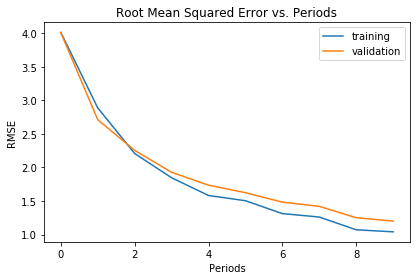

In [13]:
regressor, _, _ = train_nn_regression_model(
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.02),
    steps=1000,
    batch_size=20,
    hidden_units=[30, 30, 20, 20],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

(59, 30)
Darker corresponds to more negative, lighter corresponds to more positive.


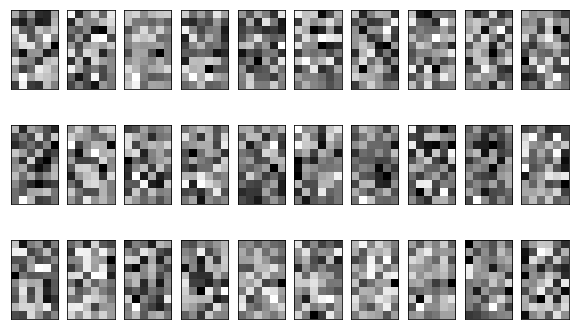

In [42]:
weights0 = regressor.get_variable_value("dnn/hiddenlayer_0/kernel")
print(weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(10, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    padded = np.pad(coef, (0, 1), "constant")
    cax = ax.matshow(np.expand_dims(padded, 0).reshape(10, 6), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())

print("Darker corresponds to more negative, lighter corresponds to more positive.")
plt.show()

In [14]:
recent_df, _, _ = preprocess_daily_adjusted_df(daily_adjusted_df.head(prediction_period + 365), 0, means, stds)
recent_features = preprocess_features(recent_df).head(prediction_period)
recent_targets = preprocess_targets(recent_df).head(prediction_period)
predict_recent_input_fn = lambda: input_fn(recent_features, recent_targets, num_epochs=1, shuffle=False)
predictions = regressor.predict(input_fn=predict_recent_input_fn)
predictions = [item["predictions"][0] for item in predictions]
display.display(predictions)

[111.45965]